In [62]:
import numpy as np
import pandas as pd
import torch
import cebra
from cebra import CEBRA
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import mode
import os
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tqdm import tqdm
import sklearn.metrics

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


# Read in data

### If you have sample time data

In [3]:
# Read in the data files
data_files = [
    r"M:\neuro2voc\task-4\data_1_750_750_400_1.pt",
    r"M:\neuro2voc\task-4\data_2_750_750_400_1.pt",
    r"M:\neuro2voc\task-4\data_3_750_750_400_1.pt"
]

label_files = [
    r"M:\neuro2voc\task-4\labels_1_750_750.pt",
    r"M:\neuro2voc\task-4\labels_2_750_750.pt",
    r"M:\neuro2voc\task-4\labels_3_750_750.pt"
]

# Load data and labels
data_list = [torch.load(file) for file in data_files]
label_list = [torch.load(file) for file in label_files]

# Check dimensions
print("Data dimensions:")
for i, data in enumerate(data_list):
    print(f"Data {i+1} shape: {data.shape}")

print("\nLabel dimensions:")
for i, labels in enumerate(label_list):
    print(f"Labels {i+1} shape: {labels.shape}")

# Concatenate data and labels
concatenated_data = torch.cat(data_list, dim=0)
concatenated_labels = torch.cat(label_list, dim=0)

print("Concatenated data shape:", concatenated_data.shape)
print("Concatenated labels shape:", concatenated_labels.shape)


C:\Users\askrb\AppData\Local\Temp\ipykernel_59556\434760127.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_list = [torch.load(file) for file in data_files]


Data dimensions:
Data 1 shape: torch.Size([417, 75, 1100])
Data 2 shape: torch.Size([191, 75, 1100])
Data 3 shape: torch.Size([2851, 75, 1100])

Label dimensions:
Labels 1 shape: torch.Size([417])
Labels 2 shape: torch.Size([191])
Labels 3 shape: torch.Size([2851])
Concatenated data shape: torch.Size([3459, 75, 1100])
Concatenated labels shape: torch.Size([3459])


C:\Users\askrb\AppData\Local\Temp\ipykernel_59556\434760127.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  label_list = [torch.load(file) for file in label_files]


### for binned data

In [42]:
folder_name = "AOI_100hz_50ms_pre_end_bin"

In [20]:
data_dir = os.path.join("M:", "neuro2voc", "task-5", folder_name, "data")
label_dir = os.path.join("M:", "neuro2voc", "task-5", folder_name, "labels")

data_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.npy')])
data_list = []
label_list = []

for file in tqdm(data_files, desc="Loading data and labels"):
    # read in data
    data_path = os.path.join(data_dir, file)
    data = np.load(data_path)
    data_list.append(data)
    
    # read in label
    label_path = os.path.join(label_dir, file)
    label = np.load(label_path)
    label_list.append(label)

assert all(data.shape[0] == 75 for data in data_list), "All data should have 75 neurons"

# Split data into train and test sets
test_ratio = 0.2
split_idx = int(len(data_list) * (1 - test_ratio))

data_train = data_list[:split_idx]
data_test = data_list[split_idx:]
label_train = label_list[:split_idx]
label_test = label_list[split_idx:]

# Concatenate train data and labels
concatenated_data_train = np.concatenate(data_train, axis=1)
concatenated_labels_train = np.concatenate([np.full(data.shape[1], label) for data, label in zip(data_train, label_train)])

# Concatenate test data and labels
concatenated_data_test = np.concatenate(data_test, axis=1)
concatenated_labels_test = np.concatenate([np.full(data.shape[1], label) for data, label in zip(data_test, label_test)])

# Convert to torch tensors
concatenated_data_train = torch.tensor(concatenated_data_train, dtype=torch.float32).T
concatenated_labels_train = torch.tensor(concatenated_labels_train, dtype=torch.long)

concatenated_data_test = torch.tensor(concatenated_data_test, dtype=torch.float32).T
concatenated_labels_test = torch.tensor(concatenated_labels_test, dtype=torch.long)

print(f"Shape of concatenated train data: {concatenated_data_train.shape}")
print(f"Shape of concatenated train labels: {concatenated_labels_train.shape}")
print(f"Shape of concatenated test data: {concatenated_data_test.shape}")
print(f"Shape of concatenated test labels: {concatenated_labels_test.shape}")

Loading data and labels: 100%|██████████| 3459/3459 [00:01<00:00, 3399.03it/s]

Shape of concatenated train data: torch.Size([42944, 75])
Shape of concatenated train labels: torch.Size([42944])
Shape of concatenated test data: torch.Size([10848, 75])
Shape of concatenated test labels: torch.Size([10848])


### Option 2 shuffled labels

In [114]:
data_dir = os.path.join("M:", "neuro2voc", "task-5", folder_name, "data")
label_dir = os.path.join("M:", "neuro2voc", "task-5", folder_name, "labels")

data_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.npy')])
data_list = []
label_list = []

for file in tqdm(data_files, desc="Loading data and labels"):
    # read in data
    data_path = os.path.join(data_dir, file)
    data = np.load(data_path)
    data_list.append(data)
    
    # read in label
    label_path = os.path.join(label_dir, file)
    label = np.load(label_path)
    label_list.append(label)

assert all(data.shape[0] == 75 for data in data_list), "All data should have 75 neurons"

# Split data into train and test sets
test_ratio = 0.2
split_idx = int(len(data_list) * (1 - test_ratio))

# Create random permutation indices
train_perm = np.random.permutation(split_idx)
test_perm = np.random.permutation(len(data_list) - split_idx) + split_idx

# Apply permutation to train and test splits
data_train = [data_list[i] for i in train_perm]
data_test = [data_list[i] for i in test_perm]
label_train = [label_list[i] for i in train_perm]
label_test = [label_list[i] for i in test_perm]

# Concatenate train data and labels with shuffled order
concatenated_data_train = np.concatenate(data_train, axis=1)
concatenated_labels_train = np.concatenate([np.full(data.shape[1], label) for data, label in zip(data_train, label_train)])

# Concatenate test data and labels with shuffled order
concatenated_data_test = np.concatenate(data_test, axis=1)
concatenated_labels_test = np.concatenate([np.full(data.shape[1], label) for data, label in zip(data_test, label_test)])

# Convert to torch tensors
concatenated_data_train = torch.tensor(concatenated_data_train, dtype=torch.float32).T
concatenated_labels_train = torch.tensor(concatenated_labels_train, dtype=torch.long)

concatenated_data_test = torch.tensor(concatenated_data_test, dtype=torch.float32).T
concatenated_labels_test = torch.tensor(concatenated_labels_test, dtype=torch.long)

print(f"Shape of concatenated train data: {concatenated_data_train.shape}")
print(f"Shape of concatenated train labels: {concatenated_labels_train.shape}")
print(f"Shape of concatenated test data: {concatenated_data_test.shape}")
print(f"Shape of concatenated test labels: {concatenated_labels_test.shape}")

Loading data and labels: 100%|██████████| 3459/3459 [00:26<00:00, 131.84it/s]


Shape of concatenated train data: torch.Size([42944, 75])
Shape of concatenated train labels: torch.Size([42944])
Shape of concatenated test data: torch.Size([10848, 75])
Shape of concatenated test labels: torch.Size([10848])


In [115]:
# check if the perm is correct
start_idx = np.random.randint(0, len(concatenated_labels_train) - 50)
labels = concatenated_labels_train[start_idx:start_idx+200].tolist()
unique_labels = []
for label in labels:
    if label not in unique_labels:
        unique_labels.append(label)
print(unique_labels)

[2, 6, 7, 3, 4, 5]


In [4]:
cebra_time_model = CEBRA(
    model_architecture='offset1-model',
    batch_size=512,
    learning_rate=3e-4,
    temperature=1.12,
    output_dimension=3,
    max_iterations=50000,
    distance='cosine',
    conditional='time',
    device='cuda_if_available',
    verbose=True,
    time_offsets=1
)

In [5]:
cebra_time_model.fit(concatenated_data_train)
cebra_time_model.save("cebra_time_model_offset1.pt")

pos: -0.4778 neg:  6.4198 total:  5.9421 temperature:  1.1200: 100%|██████████| 50000/50000 [03:51<00:00, 215.73it/s]


In [23]:
cebra_time_model_offset10 = CEBRA(
    model_architecture='offset10-model',
    batch_size=512,
    learning_rate=3e-4,
    temperature=1.12,
    output_dimension=3,
    max_iterations=50000,
    distance='cosine',
    conditional='time',
    device='cuda_if_available',
    verbose=True,
    time_offsets=10
)

In [24]:
cebra_time_model_offset10.fit(concatenated_data_train)
cebra_time_model_offset10.save("cebra_time_model_offset10.pt")

pos: -0.8450 neg:  6.4410 total:  5.5960 temperature:  1.1200: 100%|██████████| 50000/50000 [05:53<00:00, 141.48it/s]


In [65]:
cebra_time_model_offset20 = CEBRA(
    model_architecture='offset10-model',
    batch_size=512,
    learning_rate=3e-4,
    temperature=1.12,
    output_dimension=3,
    max_iterations=50000,
    distance='cosine',
    conditional='time',
    device='cuda_if_available',
    verbose=True,
    time_offsets=20
)

In [24]:
cebra_time_model_offset20.fit(concatenated_data_train)
cebra_time_model_offset20.save("cebra_time_model_offset20_2.pt")

pos: -0.8583 neg:  6.4501 total:  5.5917 temperature:  1.1200: 100%|██████████| 50000/50000 [05:46<00:00, 144.13it/s]


In [72]:
cebra_behavior_model = CEBRA(
    model_architecture='offset1-model',
    batch_size=512,
    learning_rate=3e-4,
    temperature=1,
    output_dimension=3,
    max_iterations=50000,
    distance='cosine',
    conditional='behavior',
    device='cuda_if_available',
    verbose=True,
    time_offsets=1
)

In [74]:
cebra_behavior_model.fit(concatenated_data_train, concatenated_labels_train)
# cebra_behavior_model.save("cebra_behavior_model_offset1.pt")
cebra_behavior_model.save("cebra_behavior_model_offset1_2.pt")

pos: -0.7751 neg:  7.0013 total:  6.2262 temperature:  1.0000: 100%|██████████| 50000/50000 [03:39<00:00, 228.30it/s]


In [75]:
cebra_behavior_model_10 = CEBRA(
    model_architecture='offset10-model',
    batch_size=512,
    learning_rate=3e-4,
    temperature=1,
    output_dimension=3,
    max_iterations=50000,
    distance='cosine',
    conditional='behavior',
    device='cuda_if_available',
    verbose=True,
    time_offsets=10
)

In [76]:
cebra_behavior_model_10.fit(concatenated_data_train, concatenated_labels_train)
# cebra_behavior_model.save("cebra_behavior_model_shuffled_label.pt")
cebra_behavior_model_10.save("cebra_behavior_model_offset10_2.pt")

  0%|          | 0/50000 [00:00<?, ?it/s]

pos: -0.9358 neg:  6.5291 total:  5.5933 temperature:  1.0000: 100%|██████████| 50000/50000 [05:16<00:00, 158.15it/s]


In [77]:
cebra_behavior_model_20 = CEBRA(
    model_architecture='offset10-model',
    batch_size=512,
    learning_rate=3e-4,
    temperature=1,
    output_dimension=3,
    max_iterations=50000,
    distance='cosine',
    conditional='behavior',
    device='cuda_if_available',
    verbose=True,
    time_offsets=20
)

In [78]:
cebra_behavior_model_20.fit(concatenated_data_train, concatenated_labels_train)
# cebra_behavior_model.save("cebra_behavior_model_shuffled_label.pt")
cebra_behavior_model_20.save("cebra_behavior_model_offset20_2.pt")

pos: -0.9499 neg:  6.5384 total:  5.5885 temperature:  1.0000: 100%|██████████| 50000/50000 [05:15<00:00, 158.49it/s]


In [10]:
cebra_hybrid_model  = CEBRA(
    model_architecture='offset1-model',
    batch_size=512,
    learning_rate=3e-4,
    temperature=1,
    output_dimension=3,
    max_iterations=50000,
    distance='cosine',
    conditional='time_delta',
    device='cuda_if_available',
    verbose=True,
    time_offsets=1,
    hybrid = True
)

In [11]:
n_samples = concatenated_data_train.shape[0]
time_index = np.linspace(0, 1, n_samples) 
time_index = time_index.reshape(-1, 1) 

hybrid_labels = np.column_stack([
    concatenated_labels_train, 
    time_index                 
])

In [12]:
cebra_hybrid_model.fit(concatenated_data_train, hybrid_labels)
cebra_hybrid_model.save("cebra_hybrid_model_offset1.pt")

behavior_pos: -0.3698 behavior_neg:  6.4401 behavior_total:  6.0704 time_pos: -0.5090 time_neg:  6.4401 time_total:  5.9311: 100%|██████████| 50000/50000 [06:45<00:00, 123.22it/s]


In [13]:
cebra_hybrid_model  = CEBRA(
    model_architecture='offset10-model',
    batch_size=512,
    learning_rate=3e-4,
    temperature=1,
    output_dimension=3,
    max_iterations=50000,
    distance='cosine',
    conditional='time_delta',
    device='cuda_if_available',
    verbose=True,
    time_offsets=10,
    hybrid = True
)

In [14]:
n_samples = concatenated_data_train.shape[0]
time_index = np.linspace(0, 1, n_samples) 
time_index = time_index.reshape(-1, 1) 

hybrid_labels = np.column_stack([
    concatenated_labels_train, 
    time_index                 
])

In [15]:
cebra_hybrid_model.fit(concatenated_data_train, hybrid_labels)
cebra_hybrid_model.save("cebra_hybrid_model_offset10.pt")

behavior_pos: -0.8690 behavior_neg:  6.4299 behavior_total:  5.5609 time_pos: -0.9389 time_neg:  6.4299 time_total:  5.4911: 100%|██████████| 50000/50000 [10:43<00:00, 77.74it/s]


In [90]:
cebra_hybrid_model_20  = CEBRA(
    model_architecture='offset1-model',
    batch_size=512,
    learning_rate=3e-4,
    temperature=1,
    output_dimension=3,
    max_iterations=50000,
    distance='cosine',
    conditional='time_delta',
    device='cuda_if_available',
    verbose=True,
    time_offsets=20,
    hybrid = True
)

n_samples = concatenated_data_train.shape[0]
time_index = np.linspace(0, 1, n_samples) 
time_index = time_index.reshape(-1, 1) 

hybrid_labels = np.column_stack([
    concatenated_labels_train, 
    time_index                 
])

In [91]:
cebra_hybrid_model_20.fit(concatenated_data_train, hybrid_labels)
cebra_hybrid_model_20.save("cebra_hybrid_model_offset20_2.pt")


behavior_pos: -0.6453 behavior_neg:  6.8463 behavior_total:  6.2010 time_pos: -0.6591 time_neg:  6.8463 time_total:  6.1873: 100%|██████████| 50000/50000 [06:22<00:00, 130.86it/s]


In [16]:
cebra_behavior_shuffled_model  = CEBRA(
    model_architecture='offset1-model',
    batch_size=512,
    learning_rate=3e-4,
    temperature=1,
    output_dimension=3,
    max_iterations=50000,
    distance='cosine',
    conditional='time_delta',
    device='cuda_if_available',
    verbose=True,
    time_offsets=1
)

In [17]:
shuffled_data = np.random.permutation(concatenated_data_train)

In [18]:
cebra_behavior_shuffled_model.fit(shuffled_data, concatenated_labels_train)
cebra_behavior_shuffled_model.save("cebra_behavior_shuffled_model_offset1.pt")

pos: -0.9999 neg:  7.2382 total:  6.2383 temperature:  1.0000: 100%|██████████| 50000/50000 [04:04<00:00, 204.59it/s]


In [19]:
cebra_behavior_shuffled_model_10  = CEBRA(
    model_architecture='offset10-model',
    batch_size=512,
    learning_rate=3e-4,
    temperature=1,
    output_dimension=3,
    max_iterations=50000,
    distance='cosine',
    conditional='time_delta',
    device='cuda_if_available',
    verbose=True,
    time_offsets=10
)

In [20]:
cebra_behavior_shuffled_model_10.fit(shuffled_data, concatenated_labels_train)
cebra_behavior_shuffled_model_10.save("cebra_behavior_shuffled_model_offset10.pt")

pos: -0.9818 neg:  6.9720 total:  5.9902 temperature:  1.0000: 100%|██████████| 50000/50000 [06:11<00:00, 134.76it/s]


In [27]:
cebra_behavior_shuffled_model_20  = CEBRA(
    model_architecture='offset10-model',
    batch_size=512,
    learning_rate=3e-4,
    temperature=1,
    output_dimension=3,
    max_iterations=50000,
    distance='cosine',
    conditional='time_delta',
    device='cuda_if_available',
    verbose=True,
    time_offsets=20
)

shuffled_data = np.random.permutation(concatenated_data_train)

In [28]:
cebra_behavior_shuffled_model_20.fit(shuffled_data, concatenated_labels_train)
cebra_behavior_shuffled_model_20.save("cebra_behavior_shuffled_model_offset20.pt")

pos: -1.0000 neg:  7.2344 total:  6.2344 temperature:  1.0000: 100%|██████████| 50000/50000 [06:08<00:00, 135.79it/s]


In [116]:
cebra_behavior_shuffled_model_offset1 = cebra.CEBRA.load("cebra_behavior_shuffled_model_offset1.pt")
cebra_behavior_shuffled_model_offset10 = cebra.CEBRA.load("cebra_behavior_shuffled_model_offset10.pt")
cebra_behavior_shuffled_model_offset20 = cebra.CEBRA.load("cebra_behavior_shuffled_model_offset20.pt")

embeddings_shuffled_offset1 = np.vstack((
    cebra_behavior_shuffled_model_offset1.transform(concatenated_data_train),
    cebra_behavior_shuffled_model_offset1.transform(concatenated_data_test)
))
embeddings_shuffled_offset10 = np.vstack((
    cebra_behavior_shuffled_model_offset10.transform(concatenated_data_train),
    cebra_behavior_shuffled_model_offset10.transform(concatenated_data_test)
))
embeddings_shuffled_offset20 = np.vstack((
    cebra_behavior_shuffled_model_offset20.transform(concatenated_data_train),
    cebra_behavior_shuffled_model_offset20.transform(concatenated_data_test)
))


cebra_hybrid_model_offset1 = cebra.CEBRA.load("cebra_hybrid_model_offset1.pt")
cebra_hybrid_model_offset10 = cebra.CEBRA.load("cebra_hybrid_model_offset10.pt")
cebra_hybrid_model_offset20 = cebra.CEBRA.load("cebra_hybrid_model_offset20.pt")
cebra_hybrid_model_offset20_2 = cebra.CEBRA.load("cebra_hybrid_model_offset20_2.pt")

embeddings_hybrid_offset1 = np.vstack((
    cebra_hybrid_model_offset1.transform(concatenated_data_train),
    cebra_hybrid_model_offset1.transform(concatenated_data_test)
))
embeddings_hybrid_offset10 = np.vstack((
    cebra_hybrid_model_offset10.transform(concatenated_data_train),
    cebra_hybrid_model_offset10.transform(concatenated_data_test)
))
embeddings_hybrid_offset20 = np.vstack((
    cebra_hybrid_model_offset20.transform(concatenated_data_train),
    cebra_hybrid_model_offset20.transform(concatenated_data_test)
))
embeddings_hybrid_offset20_2 = np.vstack((
    cebra_hybrid_model_offset20_2.transform(concatenated_data_train),
    cebra_hybrid_model_offset20_2.transform(concatenated_data_test)
))

cebra_behavior_model_offset1 = cebra.CEBRA.load("cebra_behavior_model_offset1.pt")
cebra_behavior_model_offset1_2 = cebra.CEBRA.load("cebra_behavior_model_offset1_2.pt")
cebra_behavior_model_offset10 = cebra.CEBRA.load("cebra_behavior_model_offset10.pt")
cebra_behavior_model_offset10_2 = cebra.CEBRA.load("cebra_behavior_model_offset10_2.pt")
cebra_behavior_model_offset20 = cebra.CEBRA.load("cebra_behavior_model_offset20.pt")
cebra_behavior_model_offset20_2 = cebra.CEBRA.load("cebra_behavior_model_offset20_2.pt")
embeddings_behavior_offset1 = np.vstack((
    cebra_behavior_model_offset1.transform(concatenated_data_train),
    cebra_behavior_model_offset1.transform(concatenated_data_test)
))
embeddings_behavior_offset1_2 = np.vstack((
    cebra_behavior_model_offset1_2.transform(concatenated_data_train),
    cebra_behavior_model_offset1_2.transform(concatenated_data_test)
))
embeddings_behavior_offset10 = np.vstack((
    cebra_behavior_model_offset10.transform(concatenated_data_train),
    cebra_behavior_model_offset10.transform(concatenated_data_test)
))
embeddings_behavior_offset10_2 = np.vstack((
    cebra_behavior_model_offset10_2.transform(concatenated_data_train),
    cebra_behavior_model_offset10_2.transform(concatenated_data_test)
))
embeddings_behavior_offset20 = np.vstack((
    cebra_behavior_model_offset20.transform(concatenated_data_train),
    cebra_behavior_model_offset20.transform(concatenated_data_test)
))
embeddings_behavior_offset20_2 = np.vstack((
    cebra_behavior_model_offset20_2.transform(concatenated_data_train),
    cebra_behavior_model_offset20_2.transform(concatenated_data_test)
))

cebra_time_model_offset1 = cebra.CEBRA.load("cebra_time_model_offset1.pt")
cebra_time_model_offset10 = cebra.CEBRA.load("cebra_time_model_offset10.pt")
cebra_time_model_offset20 = cebra.CEBRA.load("cebra_time_model_offset20.pt")

# Get embeddings for all data
embeddings_time_offset1 = np.vstack((
    cebra_time_model_offset1.transform(concatenated_data_train),
    cebra_time_model_offset1.transform(concatenated_data_test)
))
embeddings_time_offset10 = np.vstack((
    cebra_time_model_offset10.transform(concatenated_data_train),
    cebra_time_model_offset10.transform(concatenated_data_test)
))
embeddings_time_offset20 = np.vstack((
    cebra_time_model_offset20.transform(concatenated_data_train),
    cebra_time_model_offset20.transform(concatenated_data_test)
))


# Combine labels
labels_all = np.concatenate((concatenated_labels_train, concatenated_labels_test))
unique_labels = np.unique(labels_all)
label_indices = np.searchsorted(unique_labels, labels_all)

c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\cebra\integrations\sklearn\cebra.py:1436: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.loa

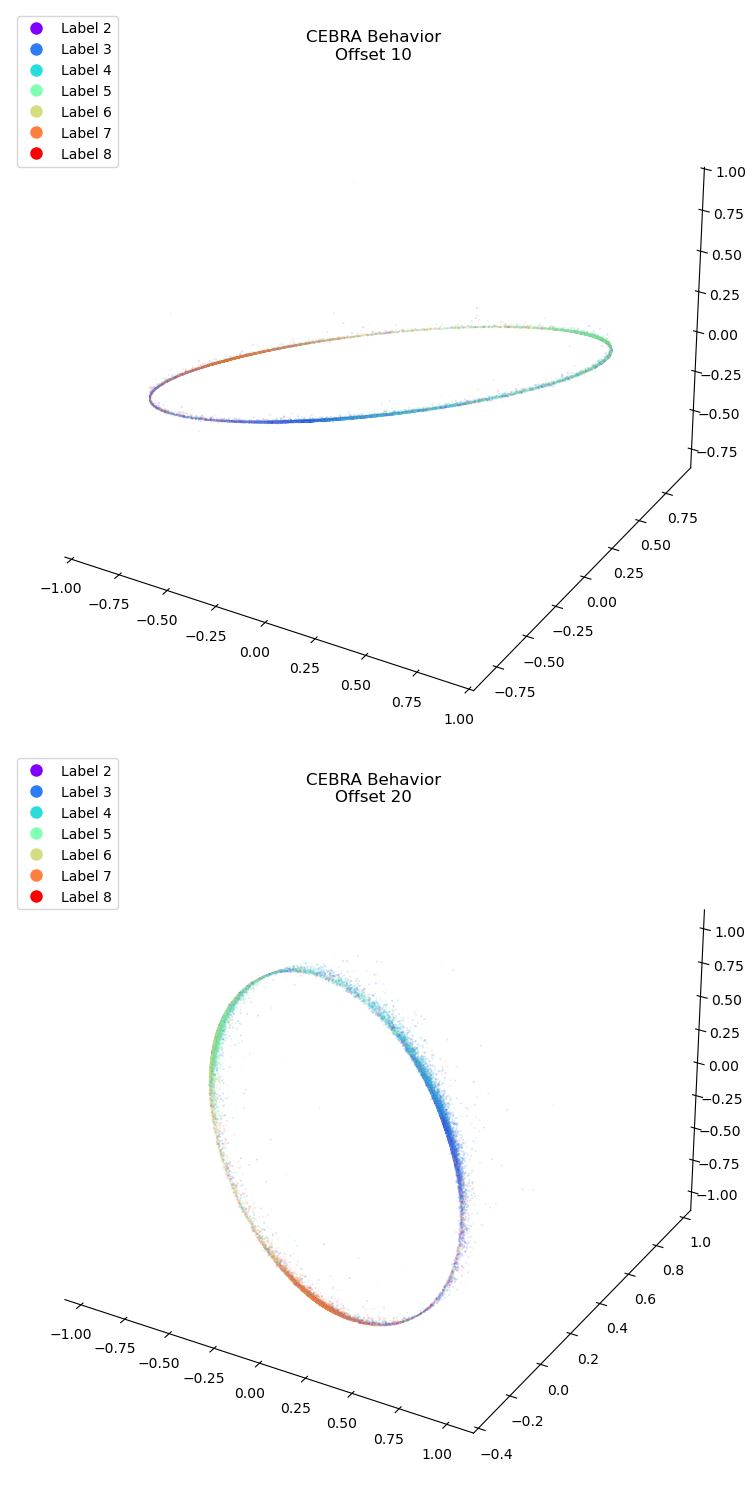

In [117]:
# Create figure with A4 proportions (1:√2 ≈ 1:1.414)
fig = plt.figure(figsize=(10, 15))  # A4 size in inches, adjusted for vertical alignment

# Create discrete colormap with one color per unique label
n_labels = len(unique_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, n_labels))
discrete_cmap = plt.cm.colors.ListedColormap(colors)

# Plot embeddings for offset 10_2  
ax1 = plt.subplot(211, projection='3d')  # Changed to 211 for vertical alignment
scatter1 = cebra.plot_embedding(ax=ax1, embedding=embeddings_behavior_offset10_2,
                    embedding_labels=label_indices,
                    cmap=discrete_cmap,
                    title='CEBRA Behavior\nOffset 10')

# Create legend for the first plot
legend_elements1 = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=discrete_cmap(i), label=f'Label {unique_labels[i]}',
                            markersize=10)
                  for i in range(len(unique_labels))]
ax1.legend(handles=legend_elements1, loc='upper left')  # Legend for ax1

# Plot embeddings for offset 20_2
ax2 = plt.subplot(212, projection='3d')  # Changed to 212 for vertical alignment
scatter2 = cebra.plot_embedding(ax=ax2, embedding=embeddings_behavior_offset20_2,
                    embedding_labels=label_indices,
                    cmap=discrete_cmap,
                    title='CEBRA Behavior\nOffset 20')

# Create legend for the second plot
legend_elements2 = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=discrete_cmap(i), label=f'Label {unique_labels[i]}',
                            markersize=10)
                  for i in range(len(unique_labels))]
ax2.legend(handles=legend_elements2, loc='upper left')  # Legend for ax2

plt.tight_layout()
plt.savefig('cebra_embedding_offsets_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

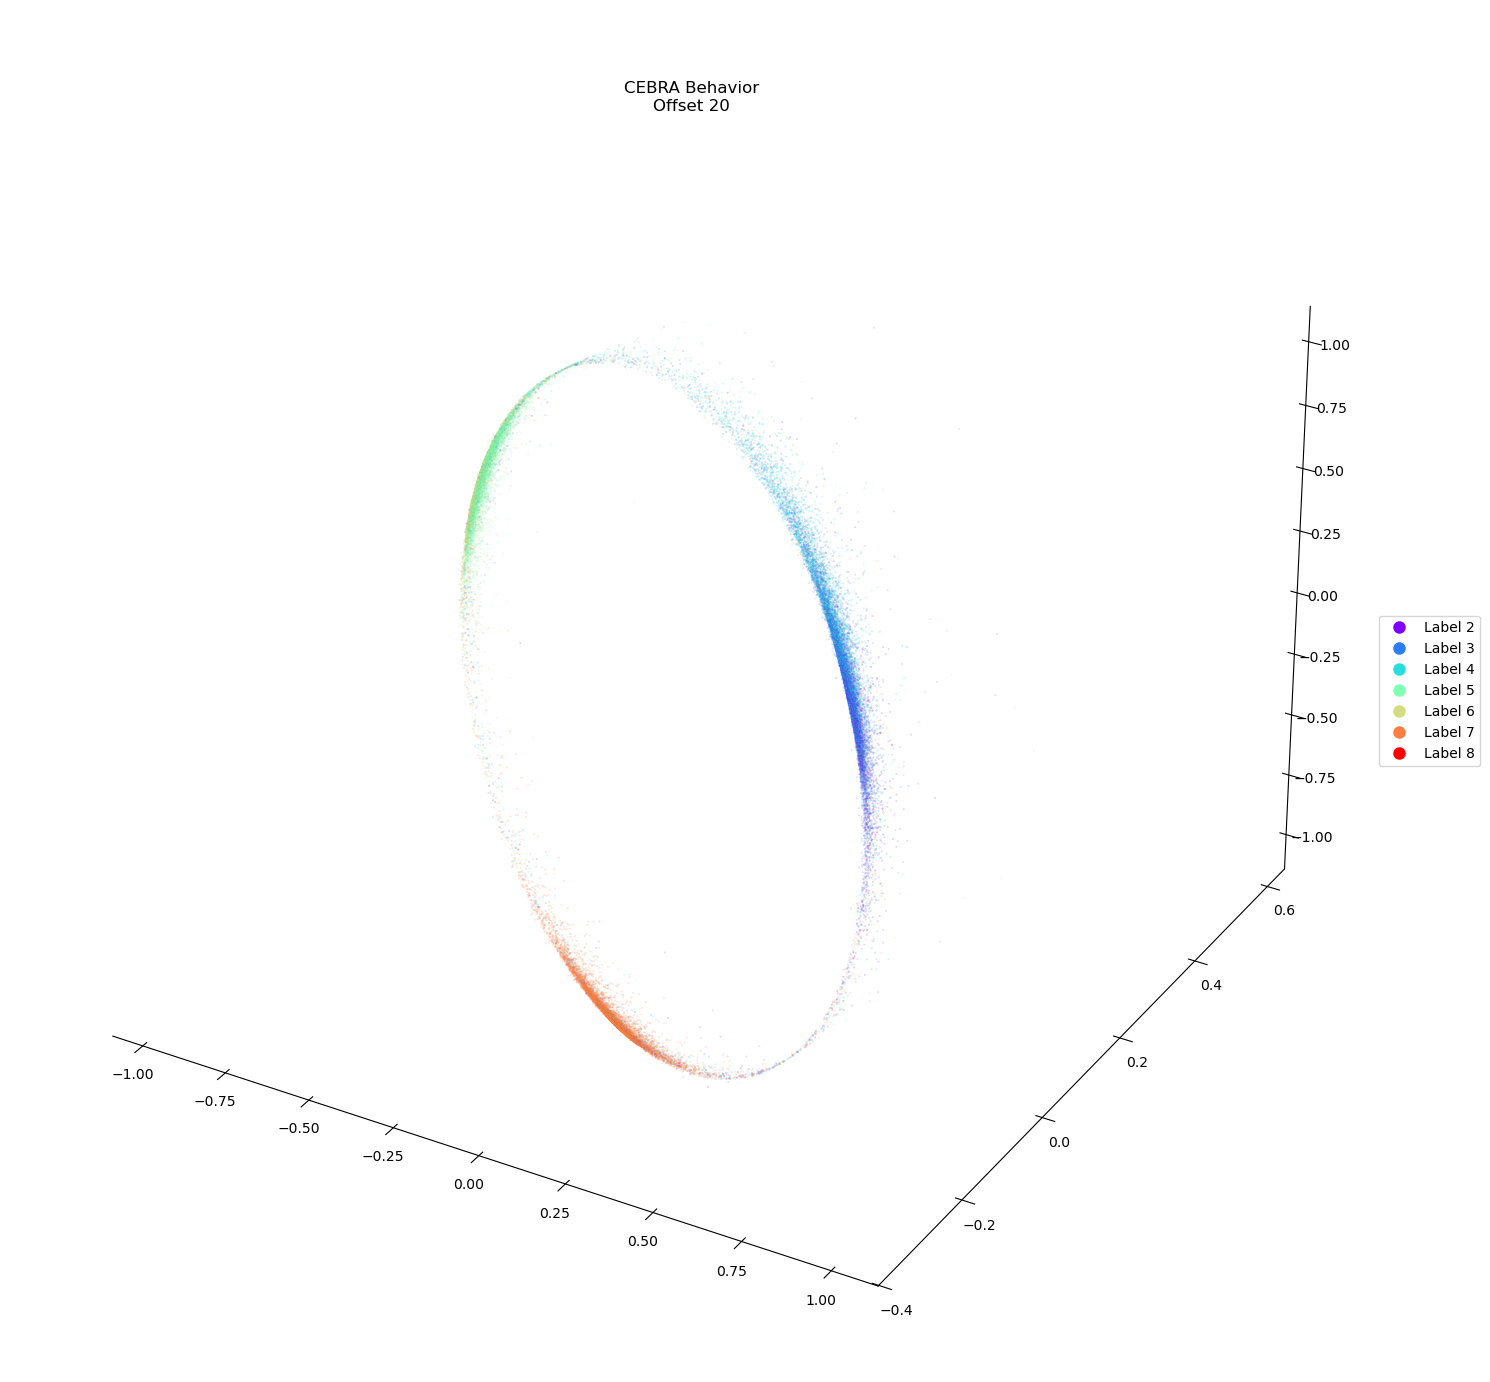

In [80]:
# Create figure with A4 proportions (1:√2 ≈ 1:1.414)
fig = plt.figure(figsize=(15, 20))  # A4 size in inches

# Plot embeddings
ax = plt.subplot(111, projection='3d')

# Create discrete colormap with one color per unique label
n_labels = len(unique_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, n_labels))
discrete_cmap = plt.cm.colors.ListedColormap(colors)

# Plot embeddings with discrete colors
scatter = cebra.plot_embedding(ax=ax, embedding=embeddings_behavior_offset20_2,
                    embedding_labels=label_indices,
                    cmap=discrete_cmap,
                    title='CEBRA Behavior\nOffset 20')

# Create legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=discrete_cmap(i), label=f'Label {unique_labels[i]}',
                            markersize=10)
                  for i in range(len(unique_labels))]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('cebra_embedding_shuffle_label_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

# # Plot legend separately
# plt.figure(figsize=(10, 8))
# ax = plt.subplot(111)
# ax.axis('off')

# # Create legend with label counts
# legend_elements = []
# for i, label in enumerate(unique_labels):
#     count = np.sum(labels_all == label)
#     legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
#                                     markerfacecolor=discrete_cmap(i), 
#                                     label=f'Label {label} (n={count})',
#                                     markersize=10))

# ax.legend(handles=legend_elements, loc='center', fontsize=12)
# plt.tight_layout()
# plt.savefig('cebra_labels.pdf', dpi=300, bbox_inches='tight')
# plt.show()

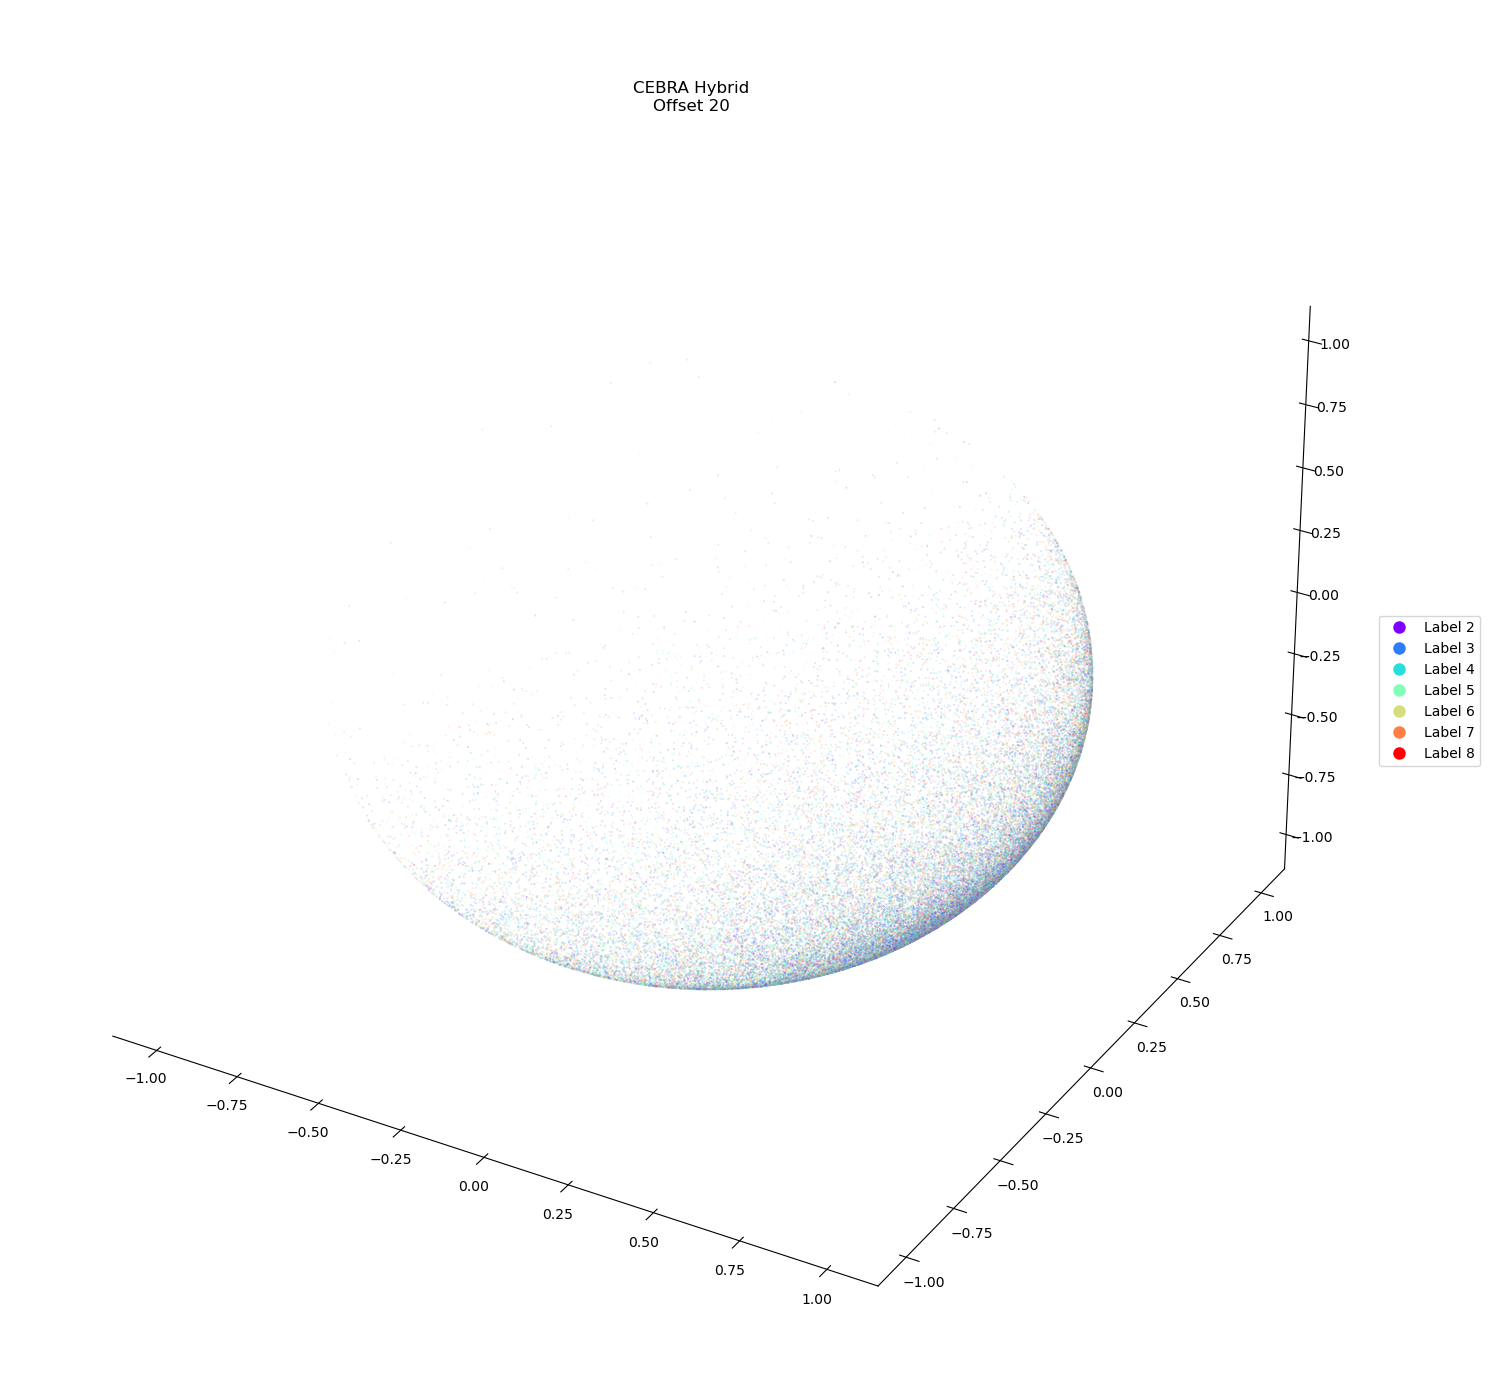

In [94]:
# Create figure with A4 proportions (1:√2 ≈ 1:1.414)
fig = plt.figure(figsize=(15, 20))  # A4 size in inches

# Plot embeddings
ax = plt.subplot(111, projection='3d')

# Create discrete colormap with one color per unique label
n_labels = len(unique_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, n_labels))
discrete_cmap = plt.cm.colors.ListedColormap(colors)

# Plot embeddings with discrete colors
scatter = cebra.plot_embedding(ax=ax, embedding=embeddings_hybrid_offset20_2,
                    embedding_labels=label_indices,
                    cmap=discrete_cmap,
                    title='CEBRA Hybrid\nOffset 20')

# Create legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=discrete_cmap(i), label=f'Label {unique_labels[i]}',
                            markersize=10)
                  for i in range(len(unique_labels))]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('cebra_embedding_hybrid_offset20_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

# # Plot legend separately
# plt.figure(figsize=(10, 8))
# ax = plt.subplot(111)
# ax.axis('off')

# # Create legend with label counts
# legend_elements = []
# for i, label in enumerate(unique_labels):
#     count = np.sum(labels_all == label)
#     legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
#                                     markerfacecolor=discrete_cmap(i), 
#                                     label=f'Label {label} (n={count})',
#                                     markersize=10))

# ax.legend(handles=legend_elements, loc='center', fontsize=12)
# plt.tight_layout()
# plt.savefig('cebra_labels.pdf', dpi=300, bbox_inches='tight')
# plt.show()

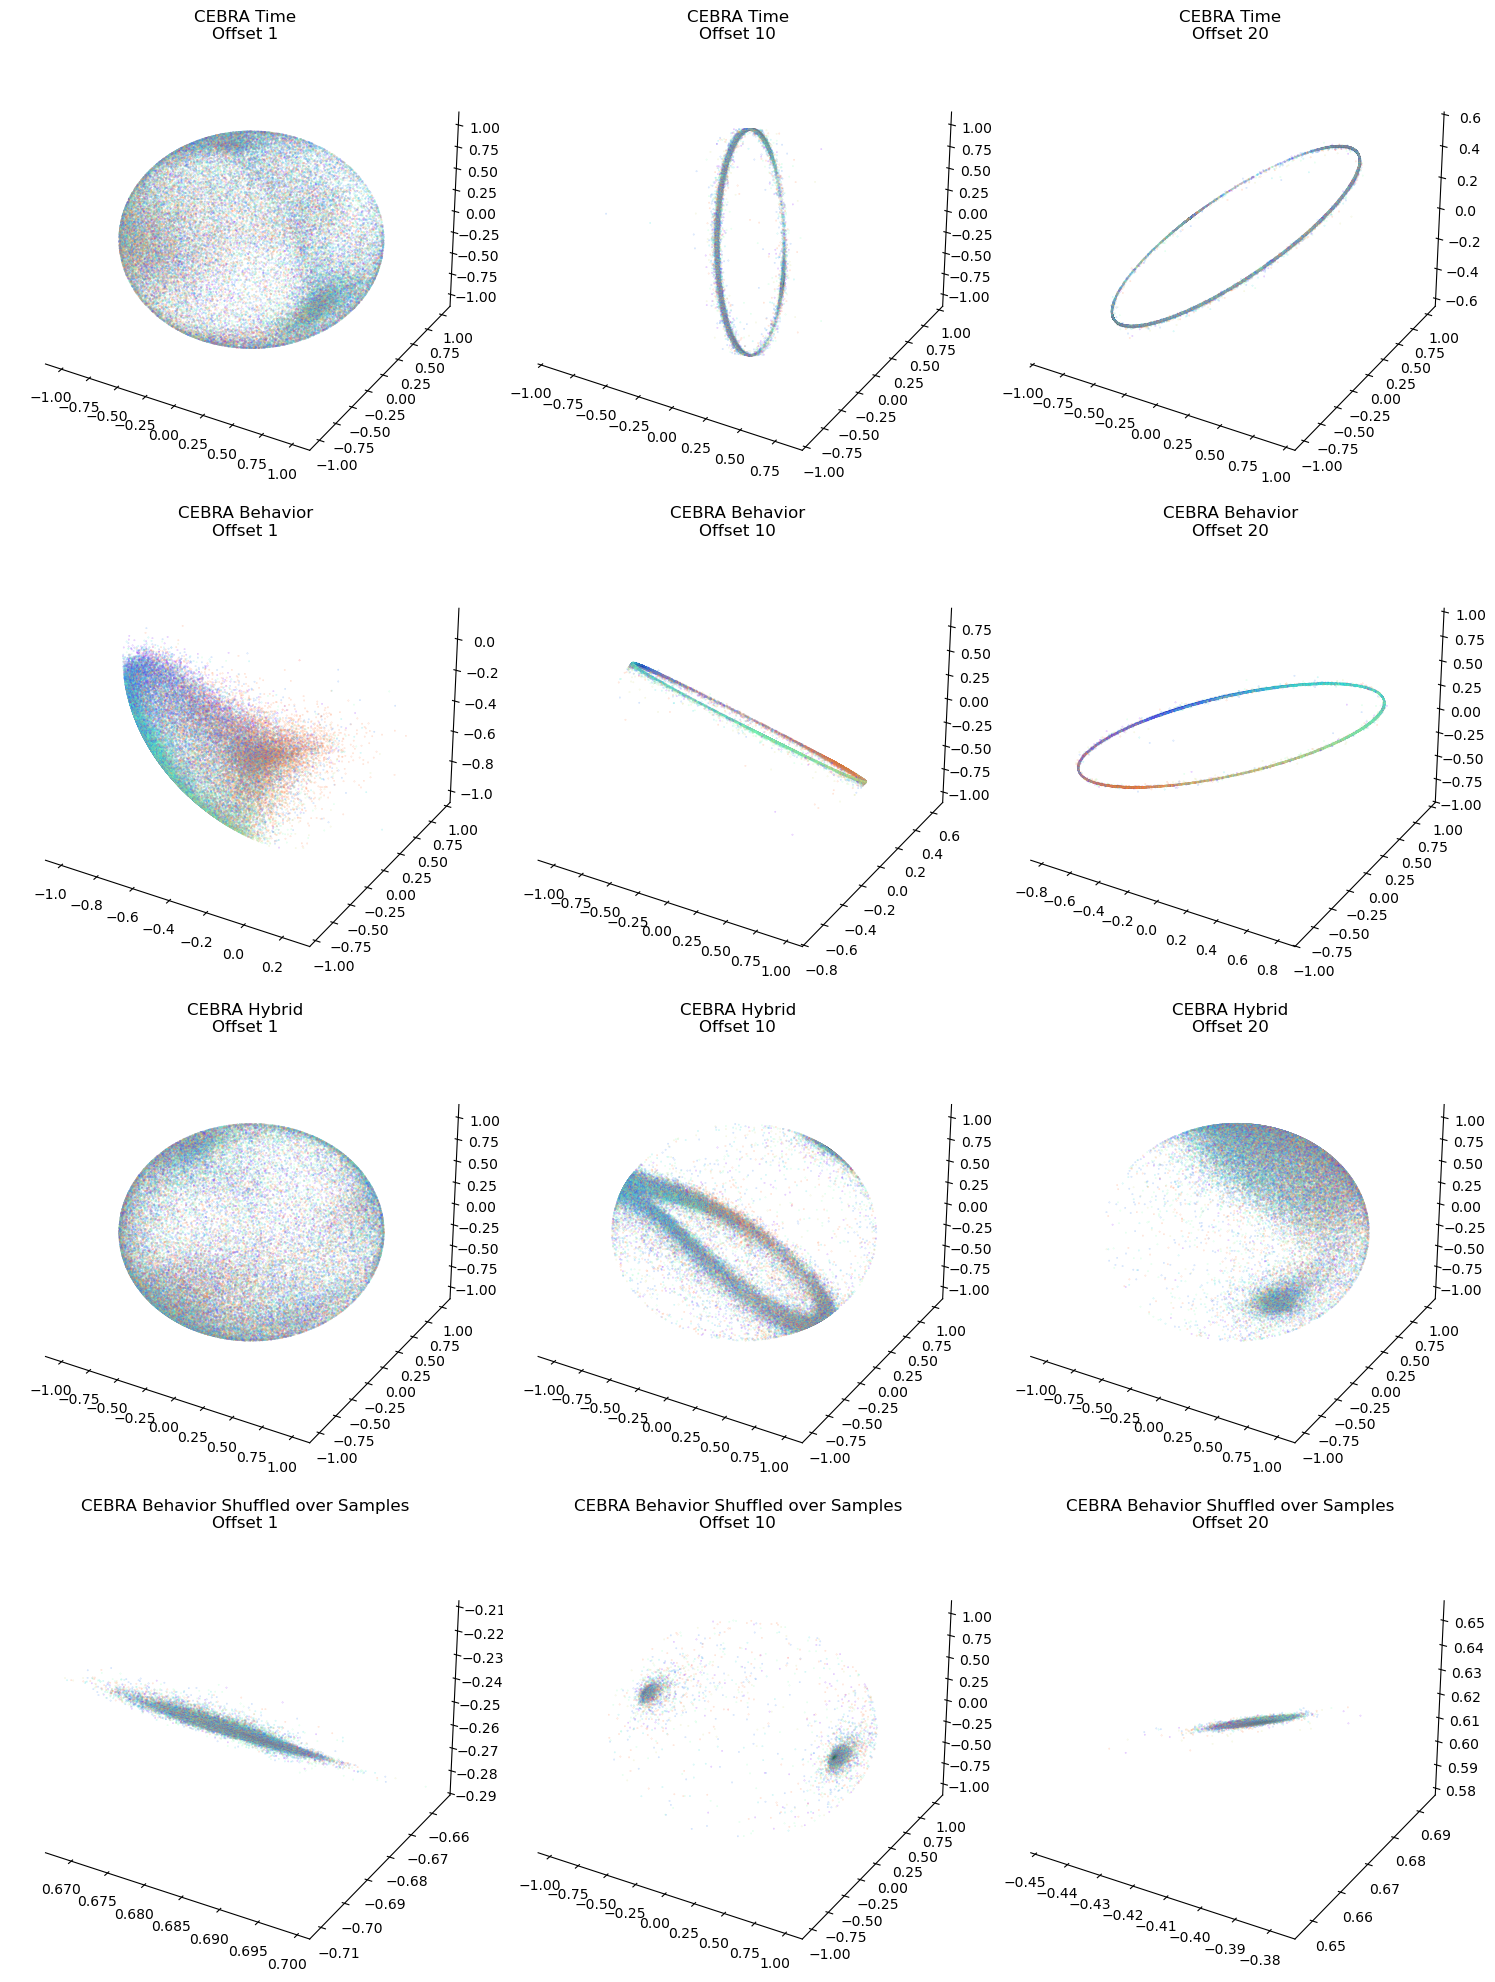

In [102]:
# Create figure with A4 proportions (1:√2 ≈ 1:1.414)
fig = plt.figure(figsize=(15, 20))  # A4 size in inches

# Plot embeddings
ax1 = plt.subplot(431, projection='3d')
ax2 = plt.subplot(432, projection='3d')
ax3 = plt.subplot(433, projection='3d')
ax4 = plt.subplot(434, projection='3d')
ax5 = plt.subplot(435, projection='3d')
ax6 = plt.subplot(436, projection='3d')
ax7 = plt.subplot(437, projection='3d')
ax8 = plt.subplot(438, projection='3d')
ax9 = plt.subplot(439, projection='3d')
ax10 = plt.subplot(4,3,10, projection='3d')
ax11 = plt.subplot(4,3,11, projection='3d')
ax12 = plt.subplot(4,3,12, projection='3d')

# Create discrete colormap with one color per unique label
n_labels = len(unique_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, n_labels))
discrete_cmap = plt.cm.colors.ListedColormap(colors)

# Plot each model's embeddings with discrete colors
cebra.plot_embedding(ax=ax1, embedding=embeddings_time_offset1,
                    embedding_labels=label_indices,
                    cmap=discrete_cmap,
                    title='CEBRA Time\nOffset 1')
cebra.plot_embedding(ax=ax2, embedding=embeddings_time_offset10,
                    embedding_labels=label_indices,
                    cmap=discrete_cmap,
                    title='CEBRA Time\nOffset 10')
cebra.plot_embedding(ax=ax3, embedding=embeddings_time_offset20,
                    embedding_labels=label_indices,
                    cmap=discrete_cmap,
                    title='CEBRA Time\nOffset 20')

cebra.plot_embedding(ax=ax4, embedding=embeddings_behavior_offset1,
                    embedding_labels=label_indices,
                    cmap=discrete_cmap,
                    title='CEBRA Behavior\nOffset 1')
cebra.plot_embedding(ax=ax5, embedding=embeddings_behavior_offset10,
                    embedding_labels=label_indices,
                    cmap=discrete_cmap,
                    title='CEBRA Behavior\nOffset 10')
cebra.plot_embedding(ax=ax6, embedding=embeddings_behavior_offset20,
                    embedding_labels=label_indices,
                    cmap=discrete_cmap,
                    title='CEBRA Behavior\nOffset 20')

cebra.plot_embedding(ax=ax7, embedding=embeddings_hybrid_offset1,
                    embedding_labels=label_indices,
                    cmap=discrete_cmap,
                    title='CEBRA Hybrid\nOffset 1')
cebra.plot_embedding(ax=ax8, embedding=embeddings_hybrid_offset10,
                    embedding_labels=label_indices,
                    cmap=discrete_cmap,
                    title='CEBRA Hybrid\nOffset 10')
cebra.plot_embedding(ax=ax9, embedding=embeddings_hybrid_offset20,
                    embedding_labels=label_indices,
                    cmap=discrete_cmap,
                    title='CEBRA Hybrid\nOffset 20')

cebra.plot_embedding(ax=ax10, embedding=embeddings_shuffled_offset1,
                    embedding_labels=label_indices,
                    cmap=discrete_cmap,
                    title='CEBRA Behavior Shuffled over Samples\nOffset 1')
cebra.plot_embedding(ax=ax11, embedding=embeddings_shuffled_offset10,
                    embedding_labels=label_indices,
                    cmap=discrete_cmap,
                    title='CEBRA Behavior Shuffled over Samples\nOffset 10')
cebra.plot_embedding(ax=ax12, embedding=embeddings_shuffled_offset20,
                    embedding_labels=label_indices,
                    cmap=discrete_cmap,
                    title='CEBRA Behavior Shuffled over Samples\nOffset 20')

plt.tight_layout()
plt.savefig('embeddings_plot.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# check if the perm is correct
start_idx = np.random.randint(0, len(concatenated_labels_train) - 50)
labels = concatenated_labels_train[start_idx:start_idx+200].tolist()
unique_labels = []
for label in labels:
    if label not in unique_labels:
        unique_labels.append(label)
print(unique_labels)

[7, 3, 5, 6, 2, 4]


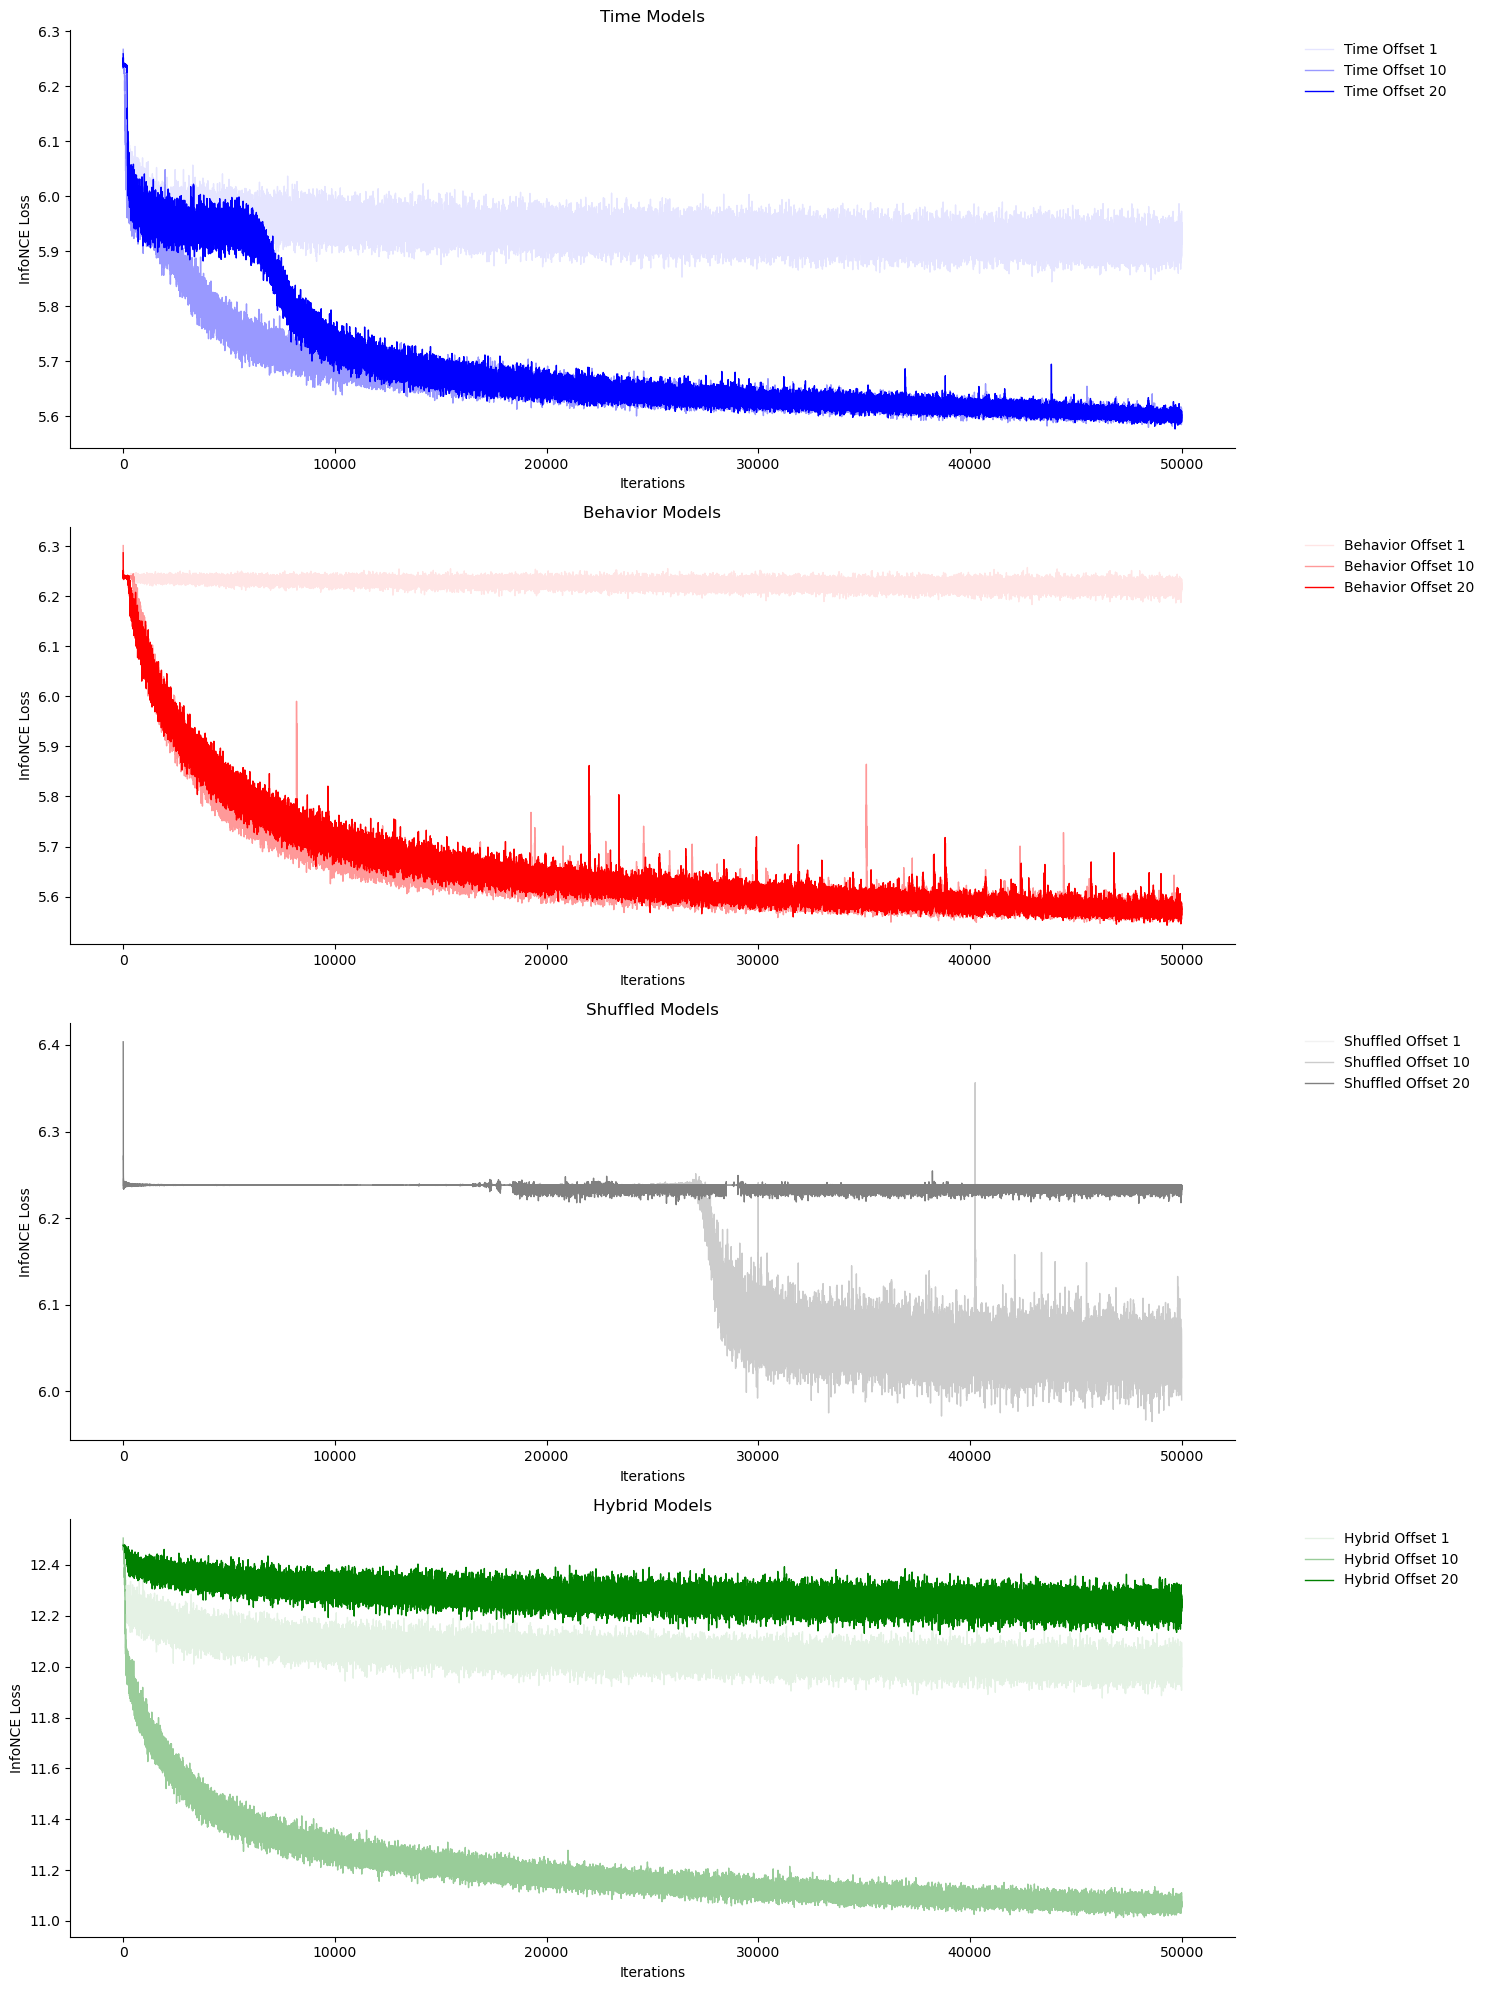

In [108]:
# Plot loss curves for each model group in separate subplots
fig = plt.figure(figsize=(15, 20))

# Define model groups and their properties
model_groups = {
    'Time': {
        'color': 'blue',
        'models': [
            (cebra_time_model_offset1, 'Time Offset 1', 0.1),
            (cebra_time_model_offset10, 'Time Offset 10', 0.4),
            (cebra_time_model_offset20, 'Time Offset 20', 1)
        ]
    },
    'Behavior': {
        'color': 'red', 
        'models': [
            (cebra_behavior_model_offset1, 'Behavior Offset 1', 0.1),
            (cebra_behavior_model_offset10, 'Behavior Offset 10', 0.4),
            (cebra_behavior_model_offset20, 'Behavior Offset 20', 1)
        ]
    },
    'Shuffled': {
        'color': 'gray',
        'models': [
            (cebra_behavior_shuffled_model_offset1, 'Shuffled Offset 1', 0.1),
            (cebra_behavior_shuffled_model_offset10, 'Shuffled Offset 10', 0.4),
            (cebra_behavior_shuffled_model_offset20, 'Shuffled Offset 20', 1)
        ]
    },
    'Hybrid': {
        'color': 'green',
        'models': [
            (cebra_hybrid_model_offset1, 'Hybrid Offset 1', 0.1),
            (cebra_hybrid_model_offset10, 'Hybrid Offset 10', 0.4),
            (cebra_hybrid_model_offset20, 'Hybrid Offset 20', 1)
        ]
    }

}

# Create subplot for each model group
for i, (group_name, group_info) in enumerate(model_groups.items(), 1):
    ax = plt.subplot(4, 1, i)
    
    # Plot each model in the group
    for model, label, alpha in group_info['models']:
        cebra.plot_loss(model,
                       color=group_info['color'],
                       alpha=alpha, 
                       label=label,
                       ax=ax)
    
    # Customize subplot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('InfoNCE Loss')
    ax.set_title(f'{group_name} Models')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

plt.tight_layout()
plt.savefig('cebra_loss.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Plot label distribution
plt.figure(figsize=(10, 8))
ax = plt.subplot(111)
unique_labels_dist, counts = np.unique(labels_all, return_counts=True)

# Create bars with rainbow colors from discrete_cmap
bars = ax.bar(unique_labels_dist, counts, color=discrete_cmap(np.linspace(0, 1, len(unique_labels_dist))))

# Customize plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_title('Distribution of Labels')

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom')

plt.show()

In [85]:
# # Create a dictionary of embeddings
# embeddings_dict = {
#     'Time Offset 1': embeddings_time_offset1,
#     'Time Offset 10': embeddings_time_offset10,
#     'Behavior Offset 1': embeddings_behavior_offset1,
#     'Behavior Offset 10': embeddings_behavior_offset10,
#     'Hybrid Offset 1': embeddings_hybrid_offset1,
#     'Hybrid Offset 10': embeddings_hybrid_offset10,
#     'Shuffled Offset 1': embeddings_shuffled_offset1,
#     'Shuffled Offset 10': embeddings_shuffled_offset10
# }

# embeddings_dict = {
#     'Time Offset 20': embeddings_time_offset20,
#     'Behavior Offset 20': embeddings_behavior_offset20,
#     'Hybrid Offset 20': embeddings_hybrid_offset20,
#     'Shuffled Offset 20': embeddings_shuffled_offset20
# }


embeddings_dict = {
    'Behavior Offset 1 2': embeddings_behavior_offset1_2,
    'Behavior Offset 10 2': embeddings_behavior_offset10_2,
    'Behavior Offset 20 2': embeddings_behavior_offset20_2
}


In [86]:
results = {}
for name, embedding in embeddings_dict.items():
    print(f"\nPerforming SVM classification for {name}:")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        embedding, label_indices, test_size=0.2, random_state=42
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create and train SVM
    svm = SVC(kernel='rbf', random_state=42)
    svm.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = svm.predict(X_test_scaled)
    
    # Calculate test score
    test_score = svm.score(X_test_scaled, y_test)
    
    # Store results
    results[name] = {
        'test_score': test_score,
        'test_report': classification_report(y_test, y_pred)
    }
    
    # Print results
    print(f"Testing score: {test_score:.6f}")


Performing SVM classification for Behavior Offset 1 2:


c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Testing score: 0.362766

Performing SVM classification for Behavior Offset 10 2:


c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Testing score: 0.639372

Performing SVM classification for Behavior Offset 20 2:
Testing score: 0.640208


c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [87]:
# Print highest validation/test accuracy for each embedding
print("Highest validation/test accuracies:")
print("-" * 40)

from sklearn.ensemble import RandomForestClassifier

# Define parameter grid for Random Forest with fewer parameter combinations
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, None], 
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Perform grid search for each embedding
results = {}
for name, embedding in embeddings_dict.items():
    print(f"\nPerforming grid search for {name}:")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        embedding, label_indices, test_size=0.2, random_state=42
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create and train GridSearchCV
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=0)
    grid_search.fit(X_train_scaled, y_train)
    
    # Print highest score for this embedding
    print(f"{name}: {grid_search.best_score_:.6f}")

Highest validation/test accuracies:
----------------------------------------

Performing grid search for Behavior Offset 1 2:
Behavior Offset 1 2: 0.355263

Performing grid search for Behavior Offset 10 2:
Behavior Offset 10 2: 0.637395

Performing grid search for Behavior Offset 20 2:
Behavior Offset 20 2: 0.641903


In [88]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Perform classification for each embedding
results = {}
for name, embedding in embeddings_dict.items():
    print(f"\nPerforming XGBoost classification for {name}:")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        embedding, label_indices, test_size=0.2, random_state=42
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create and train XGBoost classifier with simple parameters
    xgb = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.3,
        random_state=42,
        objective='multi:softmax'
    )
    xgb.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = xgb.predict(X_test_scaled)
    
    # Calculate and store accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'test_accuracy': test_accuracy
    }
    
    # Print accuracy
    print(f"Test Accuracy: {test_accuracy:.4f}")


Performing XGBoost classification for Behavior Offset 1 2:
Test Accuracy: 0.3449

Performing XGBoost classification for Behavior Offset 10 2:
Test Accuracy: 0.6398

Performing XGBoost classification for Behavior Offset 20 2:
Test Accuracy: 0.6418


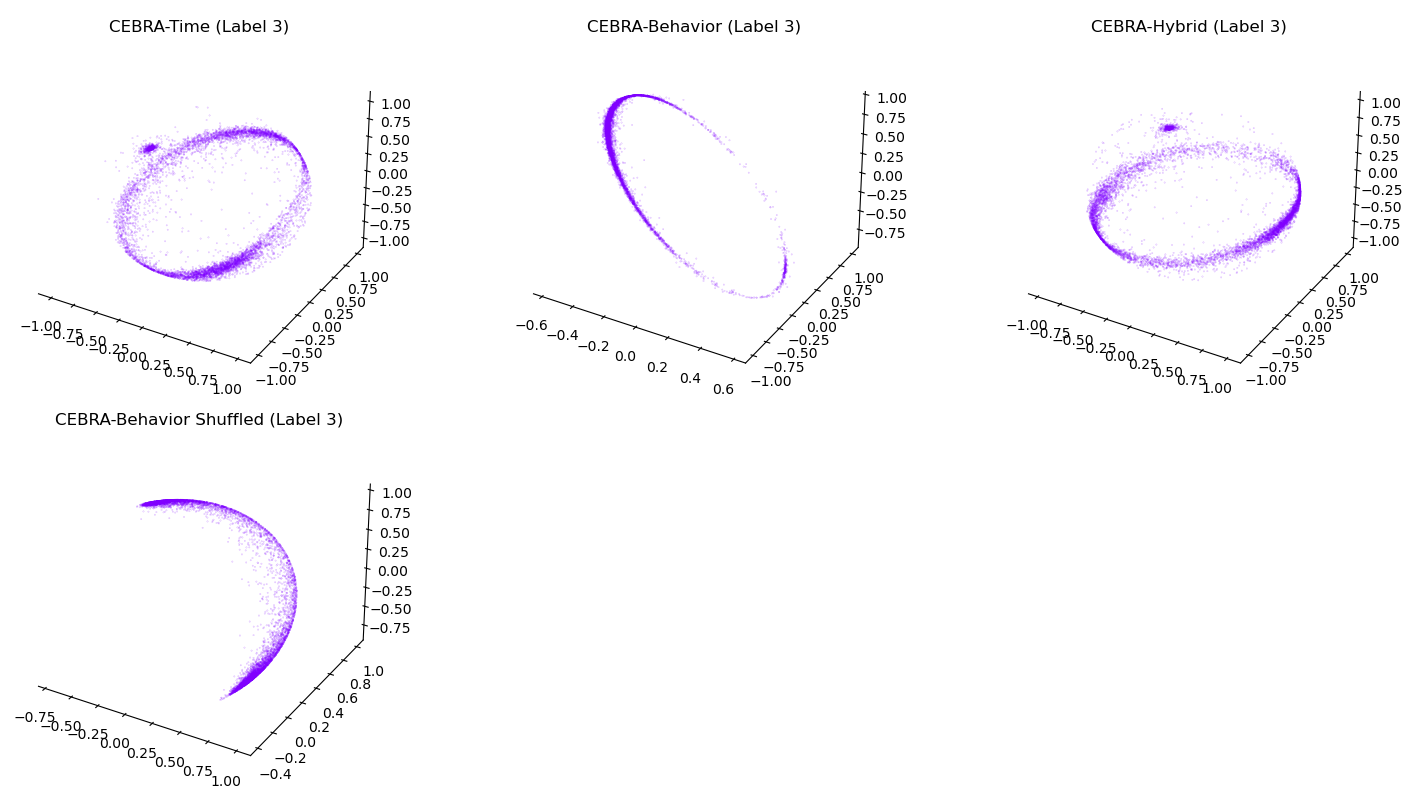

In [12]:
fig = plt.figure(figsize=(15, 8))

# Plot embeddings
ax1 = plt.subplot(231, projection='3d')
ax2 = plt.subplot(232, projection='3d')
ax3 = plt.subplot(233, projection='3d')
ax4 = plt.subplot(234, projection='3d')

# Create discrete colormap with one color per unique label
n_labels = len(unique_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, n_labels))
discrete_cmap = plt.cm.colors.ListedColormap(colors)

# Filter data for label 3
label_3_mask = label_indices == 2
embeddings_time_filtered = embeddings_time[label_3_mask]
embeddings_behavior_filtered = embeddings_behavior[label_3_mask]
embeddings_hybrid_filtered = embeddings_hybrid[label_3_mask]
embeddings_shuffled_filtered = embeddings_shuffled[label_3_mask]
labels_filtered = label_indices[label_3_mask]

# Plot each model's embeddings with discrete colors - only label 3
cebra.plot_embedding(ax=ax1, embedding=embeddings_time_filtered, 
                    embedding_labels=labels_filtered,
                    cmap=discrete_cmap,
                    title='CEBRA-Time (Label 3)')
cebra.plot_embedding(ax=ax2, embedding=embeddings_behavior_filtered, 
                    embedding_labels=labels_filtered,
                    cmap=discrete_cmap,
                    title='CEBRA-Behavior (Label 3)')
cebra.plot_embedding(ax=ax3, embedding=embeddings_hybrid_filtered, 
                    embedding_labels=labels_filtered,
                    cmap=discrete_cmap,
                    title='CEBRA-Hybrid (Label 3)')
cebra.plot_embedding(ax=ax4, embedding=embeddings_shuffled_filtered, 
                    embedding_labels=labels_filtered,
                    cmap=discrete_cmap,
                    title='CEBRA-Behavior Shuffled (Label 3)')

plt.tight_layout()
plt.show()

In [12]:
def decoding_labels(embedding_train, embedding_test, label_train, label_test):
    decoder = cebra.KNNDecoder(n_neighbors=36, metric="cosine")
    
    decoder.fit(embedding_train, label_train)
    
    prediction = decoder.predict(embedding_test)
    
    # Convert tensors to numpy arrays
    label_test_np = label_test.cpu().numpy()
    prediction_np = prediction.cpu().numpy() if isinstance(prediction, torch.Tensor) else prediction
    
    test_score = sklearn.metrics.r2_score(label_test_np, prediction_np)
    test_err = np.median(np.abs(prediction_np - label_test_np))
    
    return test_score, test_err

In [13]:
cebra_decode = decoding_labels(embeddings_train, embeddings_test, concatenated_labels_train, concatenated_labels_test)


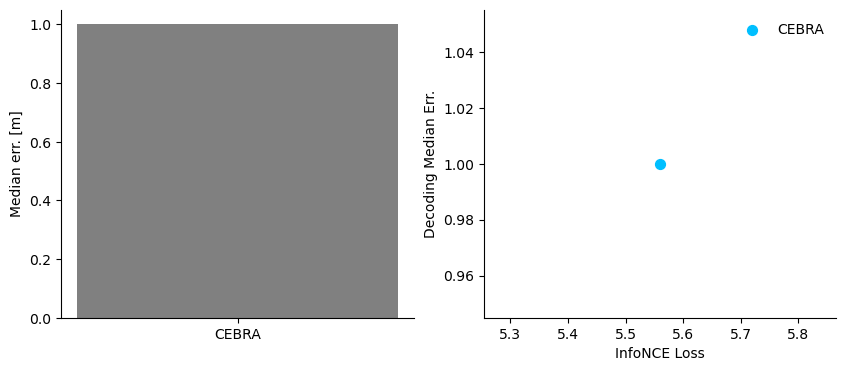

Test Score: -0.4513705818431595
Test Error: 1.0


In [14]:
# Plot results
fig = plt.figure(figsize=(10,4))

ax1 = plt.subplot(121)
ax1.bar(np.arange(1), [cebra_decode[1]], width=0.5, color='gray')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(1))
ax1.set_xticklabels(['CEBRA'])
ax1.set_ylabel('Median err. [m]')

ax2 = plt.subplot(122)
ax2.scatter(cebra_model.state_dict_['loss'][-1], cebra_decode[1], s=50, c='deepskyblue', label='CEBRA')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('InfoNCE Loss')
ax2.set_ylabel('Decoding Median Err.')
plt.legend(bbox_to_anchor=(1,1), frameon=False)
plt.show()

print(f"Test Score: {cebra_decode[0]}")
print(f"Test Error: {cebra_decode[1]}")